# Data Cleaning with Pandas

*This notebook was adapted from Melanie Walsh's "Pandas Basics", [Part 3](https://melaniewalsh.github.io/Intro-Cultural-Analytics/03-Data-Analysis/03-Pandas-Basics-Part3.html#) and [Part 4](https://melaniewalsh.github.io/Intro-Cultural-Analytics/03-Data-Analysis/04-Pandas-Merge-Datasets.html).*

In this notebook, we will expand our knowledge of pandas by discussing the following aspects of data cleaning:

- Merging datasets
- More on the dataframe `index`
- Intro to accessor functions (e.g., working with strings, datetimes, etc.)
- Applying functions
- `map`, `reduce`, and `filter`
- The `.apply` method
- `pivot` and `melt`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                 
import seaborn as sns

%config InlineBackend.figure_formats = ['svg']

# personal seaborn preferences ...
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

In [2]:
# print as in NumPy version 1.25
np.set_printoptions(legacy='1.25')

## Diversity in Film

**How many movies are actually dispropotionately featuring white men? What changes by genre, era, or box-office revenue? What circumstances generate more diversity?**

The dataset that we're working with in this lesson is taken from Hannah Andersen and Matt Daniels's *Pudding* essay, ["Film Dialogue from 2,000 screenplays, Broken Down by Gender and Age"](https://pudding.cool/2017/03/film-dialogue/). The dataset provides information about 2,000 films from 1925 to 2015, including characters’ names, genders, ages, how many words each character spoke in each film, the release year of each film, and how much money the film grossed. They included character gender information because they wanted to contribute data to a broader conversation about how "white men dominate movie roles."

Yet, transforming complex social constructs like gender into quantifiable data is tricky and historically fraught. They claim, in fact, that one of the [most frequently asked questions](https://medium.com/@matthew_daniels/faq-for-the-film-dialogue-by-gender-project-40078209f751) about the piece is about gender: E.g., *“How do you know the monster in Monsters Inc. is a boy!"* The short answer is that they don't. To determine character gender, they used actors' IMDB information, which they acknowledge is an imperfect approach: "Sometimes, women voice male characters. Bart Simpson, for example, is voiced by a woman. We’re aware that this means some of the data is wrong, AND we’re still fine with the methodology and approach."

> **What do you think about this approach to determining gender?** How does such a binary understanding of gender, gleaned from the IMDB pages of actors, influence our later results and conclusions? What do we gain by using such an approach, and what do we lose? How else might we have encoded or determined gender for the same data?

## Merging

When Andersen and Daniels published their essay, they used results from *two* related data tables. Before we proceed in this notebook, we'll merge the two.

In [3]:
df_metadata = pd.read_csv('https://raw.githubusercontent.com/melaniewalsh/Intro-Cultural-Analytics/master/book/data/Pudding/meta_data7.csv')
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   script_id   2000 non-null   int64  
 1   imdb_id     2000 non-null   object 
 2   title       2000 non-null   object 
 3   year        2000 non-null   int64  
 4   gross       1662 non-null   float64
 5   lines_data  2000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 93.9+ KB


In [4]:
df_metadata.head()

,script_id,imdb_id,title,year,gross,lines_data
0,1534,tt1022603,(500) Days of Summer,2009,37.0,7435445256774780000000000000000000000000000000...
1,1512,tt0147800,10 Things I Hate About You,1999,65.0,1777752320274530000000000000000000000000000000...
2,1514,tt0417385,12 and Holding,2005,NaN,5461357777754220000000000000000000000000000000...
3,1517,tt2024544,12 Years a Slave,2013,60.0,4567334777777780000000000000000000000000000000...
4,1520,tt1542344,127 Hours,2010,20.0,453513352345766000000000000000


In [5]:
df_metadata[df_metadata['title'].duplicated(keep=False)]

,script_id,imdb_id,title,year,gross,lines_data
553,2334,tt0080761,Friday the 13th,1980,121.0,3420055536545440000000000000000000000000000000...
554,7174,tt0758746,Friday the 13th,2009,75.0,574646233556455000000000000000000000000000000
628,6836,tt0077651,Halloween,1978,174.0,5334353752000000000000000000000000000000000000
629,4311,tt0373883,Halloween,2007,73.0,7744324410000000000000000000000000000000000000...
818,8174,tt0024216,King Kong,1933,NaN,7777654541237780000000000000000000000000000000...
819,2704,tt0360717,King Kong,2005,295.0,4133777777654440000000000000000000000000000000...
850,7922,tt3569230,Legend,2015,1.0,2745546723767640000000000000000000000000000000...
851,4515,tt0089469,Legend,1985,37.0,3343434344343580000000000000000000000000000000...
1306,7557,tt1588398,Sleeping Beauty,2011,NaN,53341024420210000000000000000000000000000000
1307,5525,tt0053285,Sleeping Beauty,1959,880.0,3021000000002200000000000000000000000000000000...


In [6]:
df_metadata['script_id'].nunique() == df_metadata.shape[0]

True

The "lines_data" column apparently contains encoded information about when during the film each character speaks. Since we don't have the means (or need) to decode it, we'll drop the column altogether.

In [7]:
df_metadata.drop(columns='lines_data', inplace=True)

They published another CSV file called "character_list5.csv" that contains, among other things, the name, gender, and age of each character as well as the number of words the character speaks.

In [8]:
df_characters = pd.read_csv('https://raw.githubusercontent.com/melaniewalsh/Intro-Cultural-Analytics/master/book/data/Pudding/character_list5.csv')
df_characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23048 entries, 0 to 23047
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   script_id            23048 non-null  int64  
 1   imdb_character_name  23046 non-null  object 
 2   words                23048 non-null  int64  
 3   gender               23048 non-null  object 
 4   age                  18263 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 900.4+ KB


In [9]:
df_characters

,script_id,imdb_character_name,words,gender,age
0,280,betty,311,f,35.0
1,280,carolyn johnson,873,f,NaN
2,280,eleanor,138,f,NaN
3,280,francesca johns,2251,f,46.0
4,280,madge,190,f,46.0
...,...,...,...,...,...
23043,9254,lumiere,1063,m,56.0
23044,9254,maurice,1107,m,71.0
23045,9254,monsieur d'arqu,114,m,58.0
23046,9254,mrs. potts,564,f,66.0


As you can see, the characters DataFrame doesn't include the actual title of the movie in which the character appears or the movie's release year or box office gross. And `df_metadata` doesn't contain any information about the characters. We want that info all in one place.

There's one column that both datasets share in common: *script_id*. If two datasets share at least one column in common, we can merge them together based the shared columns. Using the [`pd.merge()` function](https://pandas.pydata.org/docs/user_guide/merging.html#brief-primer-on-merge-methods-relational-algebra), we link each corresponding row carying the same *script_id* value. As explained in the linked documentation, this could be **one-to-one**, **one-to-many**, or **many-to-many**. For example:

    Column values [1,2,3,4,5] merged with [6,7,8,9,10] will give 0 rows
    Column values [1,2,3,4,5] merged with [1,2,3,4,5] will give 5 rows
    Column values [1,1,1,1,1] merged with [1,1,1,1,1] will give 25 rows

In [10]:
df_a = pd.DataFrame({'i': [1, 2, 2, 4, 5],
                     'from_a': ['a1', 'a2_1', 'a2_2', 'a4', 'a5']})

df_b = pd.DataFrame({'i': [2, 2, 4, 4, 6],
                     'from_b': ['b2_1', 'b2_2', 'b4_1', 'b4_2', 'b6']})

In [11]:
df_a

,i,from_a
0,1,a1
1,2,a2_1
2,2,a2_2
3,4,a4
4,5,a5


In [12]:
df_b

,i,from_b
0,2,b2_1
1,2,b2_2
2,4,b4_1
3,4,b4_2
4,6,b6


In [13]:
pd.merge(df_a, df_b, on='i', how='left')  # try the other `how` options

,i,from_a,from_b
0,1,a1,NaN
1,2,a2_1,b2_1
2,2,a2_1,b2_2
3,2,a2_2,b2_1
4,2,a2_2,b2_2
5,4,a4,b4_1
6,4,a4,b4_2
7,5,a5,NaN


In [14]:
df_films = pd.merge(df_characters, df_metadata, on='script_id')

> What does each row represent now?

### data check
Running "data checks" or "gut checks" is just a good habit to get into, so I'll show an example here of gaining confidence that our merge went smoothly.

In [15]:
# validation check
df_characters.shape, df_metadata.shape

((23048, 5), (2000, 5))

In [16]:
df_films.shape

(23048, 9)

In [17]:
df_films.sample(10)

,script_id,imdb_character_name,words,gender,age,imdb_id,title,year,gross
1223,918,william trench,1265,m,33.0,tt0240510,The Four Feathers,2002,27.0
9974,3216,carole lombard,259,f,34.0,tt0120801,RKO 281,1999,NaN
3044,1361,ayel,171,m,39.0,tt0796366,Star Trek,2009,299.0
10828,3478,state trooper,178,m,43.0,tt0324127,Suspect Zero,2004,12.0
20523,7901,senator tyson,132,m,NaN,tt1232783,Sorority Row,2009,13.0
5987,2150,father mcnulty,770,m,58.0,tt0165710,Detroit Rock City,1999,7.0
4346,1716,henry obert,2140,m,35.0,tt2114461,Authors Anonymous,2014,NaN
21049,8127,announcer,162,m,NaN,tt0117705,Space Jam,1996,177.0
10395,3345,mac,206,m,NaN,tt0258153,S1m0ne,2002,14.0
17978,6625,clarence pool,4241,m,24.0,tt0359715,My Best Friend's Birthday,1987,NaN


We can use `.duplicated` to build a Boolean series which logs duplicate rows. Rows that *are* duplicated can be counted using `.sum`.

In [18]:
df_films.duplicated().sum()

0

In [19]:
df_characters['age'].isna().sum() == df_films['age'].isna().sum()

True

In [20]:
# a bit of cleanup
df_films.rename(columns={'imdb_character_name': 'character', 
                         'year': 'release_year'}, inplace=True)

## Minding the Index

There are a few ways to create new columns:

- by modifying current columns with the `df` on both sides of the `=` sign
- by creating a new series for the dataframe\*

*\*It is possible to create a pandas Series "*outside*" of the original DataFrame, and the index will line up with the DataFrame in question.*

In [21]:
df_ = pd.DataFrame({'a': [f"a{i}" for i in range(4)]})
df_

,a
0,a0
1,a1
2,a2
3,a3


In [22]:
# df_['a'] * 3

In [23]:
series_ = pd.Series(index=[3, 1, 2, 5, 6], data=[5, 6, 7, 0, 0])
series_

3    5
1    6
2    7
5    0
6    0
dtype: int64

In [24]:
df_['series_'] = series_
df_

,a,series_
0,a0,NaN
1,a1,6.0
2,a2,7.0
3,a3,5.0


For example, let's start by looking at the total number of words and characters in each film.

In [25]:
# df_films.head()

In [26]:
df_title_words = df_films.groupby(['title', 'script_id']) \
                          .agg({'words': 'sum',
                                'character': 'nunique'
                               }) \
                          .rename(columns = {"character": "n_characters"})
df_title_words

,,words,n_characters
title,script_id,,
(500) Days of Summer,1534,18500,13
10 Things I Hate About You,1512,19680,12
12 Years a Slave,1517,19628,28
12 and Holding,1514,15968,15
127 Hours,1520,5145,4
...,...,...,...
Zero Effect,8158,13927,7
Zerophilia,3768,16686,8
Zodiac,6491,14656,31


The `groupby` operation automatically assigns the "group" to the index because it is guaranteed to be unique.

### Resetting the Index

We could reset this if we like, as we typically will when we use `groupby`.

In [27]:
df_title_words

,,words,n_characters
title,script_id,,
(500) Days of Summer,1534,18500,13
10 Things I Hate About You,1512,19680,12
12 Years a Slave,1517,19628,28
12 and Holding,1514,15968,15
127 Hours,1520,5145,4
...,...,...,...
Zero Effect,8158,13927,7
Zerophilia,3768,16686,8
Zodiac,6491,14656,31


In [28]:
df_title_words.reset_index(inplace=True)
df_title_words

,title,script_id,words,n_characters
0,(500) Days of Summer,1534,18500,13
1,10 Things I Hate About You,1512,19680,12
2,12 Years a Slave,1517,19628,28
3,12 and Holding,1514,15968,15
4,127 Hours,1520,5145,4
...,...,...,...,...
1995,Zero Effect,8158,13927,7
1996,Zerophilia,3768,16686,8
1997,Zodiac,6491,14656,31
1998,eXistenZ,6973,9447,9


### Setting the Index

And we can reverse this by picking a column **with no duplicates** to be the index. <span style='color:red'>Note: pandas will not stop you from setting a column *with* duplicates as an index, so be careful.</span>

In [29]:
df_title_words.set_index('title')

,script_id,words,n_characters
title,,,
(500) Days of Summer,1534,18500,13
10 Things I Hate About You,1512,19680,12
12 Years a Slave,1517,19628,28
12 and Holding,1514,15968,15
127 Hours,1520,5145,4
...,...,...,...
Zero Effect,8158,13927,7
Zerophilia,3768,16686,8
Zodiac,6491,14656,31


### groupby and transform

Our data only contains the number of words a character spoke in a film, but supposing we want the proportion of words from the film, we'll need `groupby` and `transform`. This will be fine because the combination of `groupby` and `transform` will return a dataframe with the same index as our data frame.

In [30]:
# intermediate step ... this index should match that of `df_films`
df_films['total_words'] = df_films.groupby('script_id')['words'] \
                                  .transform('sum')

In [33]:
# df_films[['script_id', 'words', 'total_words']]

In [34]:
df_films['proportion_of_dialogue'] = df_films['words'] / df_films['total_words']

In [ ]:
df_films[['title', 'character', 'words', 'proportion_of_dialogue']] \
    .sort_values('title')

,title,character,words,proportion_of_dialogue
3700,(500) Days of Summer,douche,134,0.007243
3709,(500) Days of Summer,vance,600,0.032432
3708,(500) Days of Summer,tom,8938,0.483135
3707,(500) Days of Summer,summer,4080,0.220541
3706,(500) Days of Summer,sarah,112,0.006054
...,...,...,...,...
3552,xXx,yorgi,1189,0.143512
3551,xXx,yelena,998,0.120459
3550,xXx,xander cage,3714,0.448280
3548,xXx,toby lee shaver,318,0.038383


#### EXERCISE

What would be a good "gut check" to verify this operation?

In [34]:
# df_films.groupby('script_id')['proportion_of_dialogue'].sum().unique()

## Accessor Objects

We've already seen many types of operations we can perform on virtually any kind of Series (or, DataFrame column), such as grouping, `transform`, adding/multiplying numbers, calculating aggregate values, etc. But, some operations which we have not discussed can only be applied to certain data types. For example, calculating a time interval makes sense given two dates, but it makes no sense given two random strings of characters.

[pandas Accessors](https://pandas.pydata.org/pandas-docs/stable/reference/series.html?highlight=accessor#accessors) are datatype-specific methods which can be applied to particular Series defined in pandas. Each one provides a vast range of operationality with their corresponding kinds of data. In this notebook, we'll give a couple examples of the accessors for [Categories](https://pandas.pydata.org/docs/user_guide/categorical.html), [Strings](https://pandas.pydata.org/docs/user_guide/text.html), and [Datetimes](https://pandas.pydata.org/docs/user_guide/timeseries.html).

### Category

To illustrate some of the nice aspects of the `.cat` accessor, let's take a look at the *age* column.

In [36]:
df_films['age'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.99])

count    18263.000000
mean        42.382960
std         59.718859
min          3.000000
10%         24.000000
25%         30.000000
50%         39.000000
75%         50.000000
99%         78.000000
max       2013.000000
Name: age, dtype: float64

Notice the maximum age ...

In [37]:
df_films[df_films['age'] > 100][['character', 'gender', 'age', 'title', 'release_year']]

,character,gender,age,title,release_year
4024,harold carnes,m,2000.0,American Psycho,2000
5254,margaret sulliv,f,2009.0,Case 39,2009
5370,bernie callo,m,2005.0,Chaos,2005
5950,realtor,m,2006.0,The Departed,2006
6899,thorpey,m,2000.0,Get Carter,2000
7787,bull,m,2007.0,Into the Wild,2007
7968,silent bob's mo,f,2001.0,Jay and Silent Bob Strike Back,2001
9233,monty malik,m,1999.0,Never Been Kissed,1999
9617,nessie,f,1993.0,The Piano,1993
9819,reporter,m,1980.0,Raging Bull,1980


Before we can even continue, we notice the age looks to be confused with the year of the movie release for several instances. There are a few ways to rectify this, but for now, we'll set incorrect age values to be missing. *What are some other ways we could manage this issue?*

In [38]:
df_films['release_year'].min()

1929

In [39]:
# something a bit more explicit than an arbitrary "max" year
mask = df_films['age'] == df_films['release_year']

<font color='darkorange'>**Before we overwrite any data, we should create a tag for each amended row.**</font>

In [ ]:
# the `mask` *is* the thing driving the updates
df_films['age_was_year'] = mask

In [41]:
# pandas NaN is actually a np.nan object
df_films.loc[mask, 'age'] = np.nan

In [42]:
df_films[mask][['title', 'age_was_year', 'age']].sample(5)

,title,age_was_year,age
14758,Scream,True,NaN
9819,Raging Bull,True,NaN
5254,Case 39,True,NaN
21635,Last Man Standing,True,NaN
4024,American Psycho,True,NaN


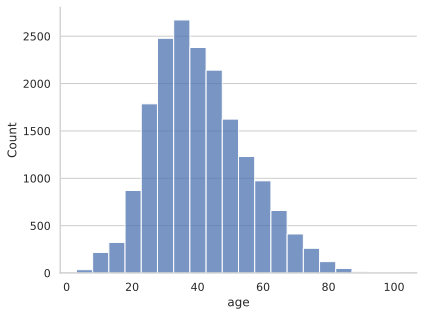

In [43]:
g = sns.histplot(data=df_films, x='age', bins=20)
# g = sns.histplot(data=df_films, x='age', hue='age_was_year', bins=20, 
#                  stat='probability', common_norm=True)

g.grid(False, axis='x');

Our goal here is to create categories based on the *age* of each character, i.e., we want "age groups". Since we should <font color='darkred'>**never choose arbitrary breaks in data**</font>, we'll use the [NIH age groups](https://www.nih.gov/nih-style-guide/age) to divide our data, and we'll translate the groups into our DataFrame using `cut`, as we've seen before.

In [44]:
df_films['age_group'] = pd.cut(df_films['age'], 
                               bins=[-1, 1, 12, 17, 65, 999],
                               labels=['Infant', 'Child', 'Adolescent', 'Adult', 'Older Adult'])

In [45]:
# data check
df_films.groupby('age_group', observed=False)['age'].agg(['min', 'max'])

,min,max
age_group,,
Infant,NaN,NaN
Child,3.0,12.0
Adolescent,13.0,17.0
Adult,18.0,65.0
Older Adult,66.0,102.0


In [46]:
df_films['age_group']

0              Adult
1                NaN
2                NaN
3              Adult
4              Adult
            ...     
23043          Adult
23044    Older Adult
23045          Adult
23046    Older Adult
23047          Adult
Name: age_group, Length: 23048, dtype: category
Categories (5, object): ['Infant' < 'Child' < 'Adolescent' < 'Adult' < 'Older Adult']

In [47]:
df_films['age_group'].cat.ordered

True

Notice, categories can be *ordered* as the are here, and we can also use `cat.codes()` to convert them to numerical values (and back).

In [48]:
#  notice the use of `.cat` here
pd.concat((df_films['age_group'], 
           df_films['age_group'].cat.codes), axis=1).drop_duplicates()

,age_group,0
0,Adult,3
1,NaN,-1
46,Adolescent,2
80,Older Adult,4
116,Child,1


In [49]:
df_films['age_group'].cat.categories

Index(['Infant', 'Child', 'Adolescent', 'Adult', 'Older Adult'], dtype='object')

Since the categories are ordered, we should see them show up "in order" in Seaborn plots, too. For example, suppose we are interested in looking at how the age group distribution in movies changes over the years.

In [50]:
df_films.head()

,script_id,character,words,gender,age,imdb_id,title,release_year,gross,total_words,proportion_of_dialogue,age_was_year,age_group
0,280,betty,311,f,35.0,tt0112579,The Bridges of Madison County,1995,142.0,6394,0.048639,False,Adult
1,280,carolyn johnson,873,f,NaN,tt0112579,The Bridges of Madison County,1995,142.0,6394,0.136534,False,NaN
2,280,eleanor,138,f,NaN,tt0112579,The Bridges of Madison County,1995,142.0,6394,0.021583,False,NaN
3,280,francesca johns,2251,f,46.0,tt0112579,The Bridges of Madison County,1995,142.0,6394,0.352049,False,Adult
4,280,madge,190,f,46.0,tt0112579,The Bridges of Madison County,1995,142.0,6394,0.029715,False,Adult


For this, we need a number of characters for each `release_year` - `age_group` combination.

In [52]:
df_films_by_year = df_films.groupby(['release_year', 'age_group'], 
                                    observed=True)['character'] \
                            .agg([('num_characters', 'count')]).reset_index()
df_films_by_year.head()

,release_year,age_group,num_characters
0,1929,Adult,6
1,1931,Adult,11
2,1931,Older Adult,1
3,1932,Adult,43
4,1932,Older Adult,4


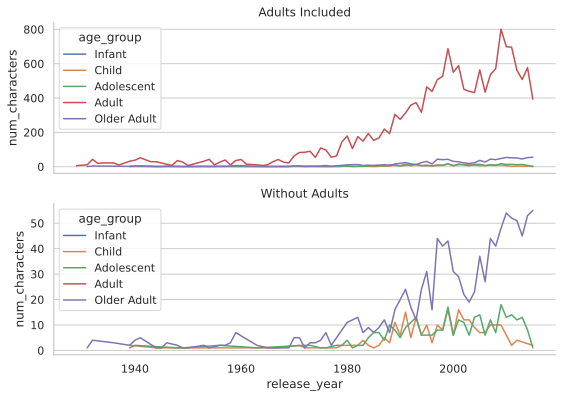

In [53]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(9, 6))

# adults included
sns.lineplot(df_films_by_year, x='release_year', y='num_characters', 
             hue='age_group', ax=axes[0])
axes[0].grid(False, axis='x')
axes[0].set_title("Adults Included")

# adults excluded
mask = df_films_by_year['age_group'] != 'Adult'
sns.lineplot(df_films_by_year[mask], x='release_year', y='num_characters', 
             hue='age_group', ax=axes[1])
axes[1].grid(False, axis='x')
axes[1].set_title("Without Adults");

### EXERCISE

What are some issues with these plots? Try to come up with at least one issue with the above data visualizations, and edit (or, rewrite) the code to build a different view of the data.

### String

pandas also provides accessors objects for strings. Built from the Python string methods, the pandas string methods will transform each string value in a column, and run the operator called after `.str`.

| **Pandas String Method** | **Explanation**                                                                                   |
|:-------------:|:---------------------------------------------------------------------------------------------------:|
| df['column_name']`.str.lower()`         | makes the string in each row lowercase                                                                                |
| df['column_name']`.str.upper()`         | makes the string in each row uppercase                                                |
| df['column_name']`.str.title()`         | makes the string in each row titlecase                                                |
| df['column_name']`.str.replace('old string', 'new string')`      | replaces `old string` with `new string` for each row |
| df['column_name']`.str.contains('some string')`      | tests whether string in each row contains "some string" |
| df['column_name']`.str.split('delim')`          | returns a list of substrings separated by the given delimiter |
| df['column_name']`.str.join(list)`         | opposite of split(), joins the elements in the given list together using the string                                                                        |
                                                            

For example, to transform every character's name in the "character" column from all lowercase to title case (i.e., capitalize the first letter of each "word"), we can use `.str.title()` .

In [54]:
df_films['character'] = df_films['character'].str.title()
df_films['character'].head()

0              Betty
1    Carolyn Johnson
2            Eleanor
3    Francesca Johns
4              Madge
Name: character, dtype: object

If we want to replace the gender column's single letter abbreviation to "male" / "female", we could use the `.str.replace()` method. 

In [55]:
df_films['gender'] = df_films['gender'].str.replace('m', 'male')

In [56]:
df_films['gender'] = df_films['gender'].str.replace('f', 'female')

In [57]:
df_films.sample(5)

,script_id,character,words,gender,age,imdb_id,title,release_year,gross,total_words,proportion_of_dialogue,age_was_year,age_group
16148,5435,Ben Hull,1784,male,69.0,tt2639344,Love Is Strange,2014,2.0,10062,0.177301,False,Older Adult
7994,2679,Laurel Boyd,804,female,35.0,tt0116695,Jerry Maguire,1996,303.0,20432,0.039350,False,Adult
8149,2714,Martin,343,male,25.0,tt0478311,Knocked Up,2007,188.0,24776,0.013844,False,Adult
4375,1718,Tsu'Tey,502,male,35.0,tt0499549,Avatar,2009,882.0,17432,0.028798,False,Adult
4699,1815,Supervisor,232,male,NaN,tt0095250,The Big Blue,1988,NaN,18114,0.012808,False,NaN


We can use the `.str.contains()` to search for particular words or phrases in a column, such as "Star Wars."

In [58]:
df_films[df_films['title'].str.contains('Star Wars')].sample(5)

,script_id,character,words,gender,age,imdb_id,title,release_year,gross,total_words,proportion_of_dialogue,age_was_year,age_group
10635,3437,Yoda,312,male,55.0,tt0120915,Star Wars: Episode I - The Phantom Menace,1999,813.0,10738,0.029056,False,Adult
10607,3433,Captain Needa,108,male,42.0,tt0080684,Star Wars: Episode V - The Empire Strikes Back,1980,937.0,9233,0.011697,False,Adult
10631,3437,Senator Palpati,551,male,55.0,tt0120915,Star Wars: Episode I - The Phantom Menace,1999,813.0,10738,0.051313,False,Adult
3021,1359,Han Solo,835,male,41.0,tt0086190,Star Wars: Episode VI - Return of the Jedi,1983,853.0,5090,0.164047,False,Adult
3039,1360,Taun We,139,female,40.0,tt0121765,Star Wars: Episode II - Attack of the Clones,2002,465.0,7515,0.018496,False,Adult


### Datetime

The pandas `datetime` object contains several different [methods](https://pandas.pydata.org/pandas-docs/stable/reference/series.html?highlight=accessor#datetimelike-properties) which can be used to shed light on date/datetime data, but the benefit of using them is most apparent when we have dates/times down to the day or even hour. In `df_films`, we only have year aggregation, so it would be difficult to show the benefits of the datetime accessor.

We will discuss datetime Series in-depth when we cover Time Series data in a later lesson, but for now we'll introduce them using a related data set found on [Box Office Mojo](https://www.boxofficemojo.com), namely the 2024 [top 200 box office films](https://www.boxofficemojo.com/year/2024).

**A Quick Note on Web Scraping**

Web scraping is a method by which we collect data from websites online using code. There are several Python packages built specifically for web scraping (e.g., [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/), and [Scrapy](https://scrapy.org/)), but this method of collecting data is usually less effective than other alternatives we'll discuss in future lessons. That said, when web scraping actually is more effective, usually the website uses HTML tables, which pandas can parse using `read_html`.

In [69]:
# see the documentation on `read_html`
df_mojo = pd.read_html('https://www.boxofficemojo.com/year/2024', 
                       match='Rank')[0]
df_mojo.head()

,Rank,Release,Genre,Budget,Running Time,Gross,Theaters,Total Gross,Release Date,Distributor,Estimated
0,1,Inside Out 2,-,-,-,"$652,980,194",4440,"$652,980,194",Jun 14,Walt Disney Studios Motion Pictures,False
1,2,Deadpool & Wolverine,-,-,-,"$636,745,858",4330,"$636,745,858",Jul 26,Walt Disney Studios Motion Pictures,False
2,3,Wicked,-,-,-,"$432,943,285",3888,"$473,231,120",Nov 22,Universal Pictures,False
3,4,Moana 2,-,-,-,"$404,017,489",4200,"$460,405,297",Nov 27,Walt Disney Studios Motion Pictures,False
4,5,Despicable Me 4,-,-,-,"$361,004,205",4449,"$361,004,205",Jul 3,Universal Pictures,False


In [70]:
df_mojo[['Genre', 'Budget', 'Running Time', 'Estimated']].describe()

,Genre,Budget,Running Time,Estimated
count,200,200,200,200
unique,1,1,1,1
top,-,-,-,False
freq,200,200,200,200


In [71]:
# these are some columns we don't need
df_mojo.drop(columns=['Genre', 'Budget', 'Running Time', 'Estimated'], 
             inplace=True)

In [72]:
# clean up column names using a dictionary comprehension
df_mojo.rename(columns={c:c.lower().replace(" ", "_") for c in df_mojo.columns},
               inplace=True)

In [73]:
df_mojo.columns

Index(['rank', 'release', 'gross', 'theaters', 'total_gross', 'release_date',
       'distributor'],
      dtype='object')

In [74]:
df_mojo['release_date']

0      Jun 14
1      Jul 26
2      Nov 22
3      Nov 27
4       Jul 3
        ...  
195     Mar 8
196    Jan 18
197     Dec 6
198    Apr 10
199     Feb 9
Name: release_date, Length: 200, dtype: object

In [75]:
df_mojo['release_date'].iloc[0]

'Jun 14'

It's a bit rare to see a date column without a year. Since we know the year for all of these is 2024 (this comes from the 2024 box office), we can tack that on to the release date using the `+` operator. Then, `pd.to_datetime` is the [preferred method](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) to parse and convert a date-looking string into a datetime object.

In [76]:
df_mojo['release_date'] = pd.to_datetime(df_mojo['release_date'] + " 2024")

In [77]:
df_mojo['release_date']

0     2024-06-14
1     2024-07-26
2     2024-11-22
3     2024-11-27
4     2024-07-03
         ...    
195   2024-03-08
196   2024-01-18
197   2024-12-06
198   2024-04-10
199   2024-02-09
Name: release_date, Length: 200, dtype: datetime64[ns]

Let's make a column for the month of the release, and another one for the quarter.

In [78]:
df_mojo['release_month'] = df_mojo['release_date'].dt.month
df_mojo['release_quarter'] = df_mojo['release_date'].dt.quarter

## Applying Functions

### Lambda Functions

Before we go on, let's take a quick aside from pandas to introduce [anonymous functions](https://realpython.com/python-lambda/#anonymous-functions), or in Python "lambda functions". As we've seen before, we can define "named" functions `myfunc` in Python using the standard `def` and `return` syntax, and then call them with parentheses `myfunc()`. But, it's not always the case that you need a function that can be called, rather you want to use the power of a function within another method. For this, we use a lambda function, which is set to take in some set of variables, and return a result.

    lambda var1: f(var1)
    lambda var1, var2: f(var1, var2)

In [81]:
f_ = lambda x: x+4
f_(3)

7

For example, suppose we are given a list of full names, and we want to sort them based on the last name.

In [82]:
names = ["Jean-Luc Picard", "Beverly Crusher", 
         "Deanna Troi", "William Riker", "Geordi LaForge"]
sorted(names)

['Beverly Crusher',
 'Deanna Troi',
 'Geordi LaForge',
 'Jean-Luc Picard',
 'William Riker']

In [83]:
sorted(names, key=lambda n: n.split(" ")[1])

['Beverly Crusher',
 'Geordi LaForge',
 'Jean-Luc Picard',
 'William Riker',
 'Deanna Troi']

### Map, Filter, and Reduce

Another use for lambda functions (outside of pandas, that is) involves using `map`, `filter`, or `reduce` functions.

In [84]:
from functools import reduce

The `map` function "applies" a given function to each element of an iterable. It returns a [*generator*](https://realpython.com/introduction-to-python-generators/#understanding-generators) object, which as we've seen before needs to be iterated through. **Think of a generator like a slide deck**, where the thing itself doesn't reveal any of its elements until you are ready for the "next slide". Also like a slide deck, when it's over, it's over.

In [85]:
names

['Jean-Luc Picard',
 'Beverly Crusher',
 'Deanna Troi',
 'William Riker',
 'Geordi LaForge']

In [86]:
first_names = map(lambda n: n.split(" ")[0], names)

In [87]:
# run this cell until you can't anymore ...
next(first_names)

'Jean-Luc'

In [88]:
# after running the above cell, we need to redefine the generator
first_names = map(lambda n: n.split(" ")[0], names)
[i for i in first_names]

['Jean-Luc', 'Beverly', 'Deanna', 'William', 'Geordi']

In [75]:
# after running the above cell, try running this cell
# [i for i in first_names]

`filter` is similar to `map` in that it returns a generator, but its purpose is to *filter* the elements of the iterable based on some condition.

In [89]:
hyphenated_names = filter(lambda n: "-" in n, names)
[i for i in hyphenated_names]

['Jean-Luc Picard']

Lastly, `reduce` is meant to combine elements into one. It uses a function which (typically) takes in two variables. This function is applied to the first two elements of the iterable, and then its applied to the resulting value and the next element of the iterable, and so on.

    reduce(lambda a, b: f(a, b), [e1, e2, e3, e4, e5])
    
    step 1: f(e1, e2) ---> R1
    step 2: f(R1, e3) ---> R2
    step 3: f(R2, e4) ---> R3
    step 4: f(R3, e5) ---> final result

For example, we can use it to compute an average of a set of numbers. 

In [90]:
list_of_numbers = [5, 4, 2, 7, 19]

In [ ]:
# calculate the sum
reduce(lambda a, b: a + b, list_of_numbers)

37

In [92]:
# calculate the average
reduce(lambda a, b: a + b, list_of_numbers) / len(list_of_numbers)

7.4

In [93]:
np.mean(list_of_numbers)

7.4

Or, further, an average of averages, if we combine `map` with `reduce`.

In [94]:
list_of_samples = [[1, 4, 3], 
                   [5, 4, 2], 
                   [9, 2, 1]]

In [95]:
list_of_averages = map(np.mean, list_of_samples)

In [96]:
# sum of three values over 3
reduce(lambda a, b: a + b, list_of_averages) / len(list_of_samples)

3.444444444444444

In [97]:
# this list comprehension will flatten a list of lists
l = [e for sublist in list_of_samples for e in sublist]
l

[1, 4, 3, 5, 4, 2, 9, 2, 1]

In [98]:
# the average of averages is the average of the full set
np.mean(l)

3.4444444444444446

Note, ["Map-Reduce"](https://en.wikipedia.org/wiki/MapReduce) is actually a process by which (a cluster of) computers can manage processing on huge (petabyte-scale) datasets, and it uses an application of exactly the same idea above, just on a much larger scale.

### Apply Functions

Using the same sort of thinking we've illustrated above, we can *apply* functions (lambda or otherwise) across all values in a column (or, any number of columns) using `.apply`. For instance, in `df_films`, we notice that character names are sometimes single names (like "Peter"), and other times, they contain last names or sometimes even middle names. Let's make a column that counts the number of "sub-names" in a characters name.

In [99]:
df_films['character'].sample(10)

9287            De Rossi
10996               Mary
8938        Annie Wilkes
11617            Eleanor
11156               Yung
21362        Mary Loomis
18922           Clifford
18659    Palace Chamberl
8014         Jack Martin
7551     Dr. Nathan Bron
Name: character, dtype: object

In [100]:
def subnames(name):
    '''
    Using the idea that multiple subnames can only occur with a space, we 
    count the spaces, and add one to get the number of subnames.
    '''
    # what if the character name is missing?
    if pd.isna(name):
        n_subnames = 0
    else:
        n_subnames = name.count(" ") + 1
        
    return n_subnames

In [101]:
df_films['n_character_subnames'] = df_films['character'].apply(subnames)

We should check this before moving on ...

In [102]:
df_films['n_character_subnames'].unique()

array([1, 2, 3, 4, 7, 5, 8, 0, 6, 9])

In [103]:
df_films[['character', 'n_character_subnames']] \
    .sort_values('n_character_subnames')

,character,n_character_subnames
19448,NaN,0
4656,NaN,0
23038,Belle,1
23043,Lumiere,1
23044,Maurice,1
...,...,...
8089,Fidget (C,8
11553,Chet (Sce,8
2959,Gregory (,8
9250,Smokey (A,8


Greater than four subnames seems a bit odd. To investigate this particular number of subnames (as a start), we can also use `.apply` on the column axis. In this way, the function is taking in a row (i.e., a pandas Series).

In [104]:
def messy_name(row):
    # this number 
    if row['n_character_subnames'] > 4:
        subnames = row['character'].split(" ")
    else:
        subnames = "not messy"
    return subnames

In [105]:
df_films['messy_name'] = df_films.apply(messy_name, axis=1)

In [106]:
cols = ['character', 'n_character_subnames', 'messy_name']
df_films[df_films['messy_name'] != "not messy"][cols]

,character,n_character_subnames,messy_name
1449,Mr. Borgin,7,"[Mr., Borgin, , , , , ]"
2623,Riff Raff - A H,5,"[Riff, Raff, -, A, H]"
2959,Gregory (,8,"[Gregory, , , , , , , (]"
4723,Sam - Man In Di,5,"[Sam, -, Man, In, Di]"
5026,Ward Abbott,6,"[Ward, Abbott, , , , ]"
6088,Clinic Girl,6,"[Clinic, Girl, , , , ]"
7077,Clerk (U,9,"[Clerk, , , , , , , , (U]"
7303,Watts (Ar,8,"[Watts, , , , , , , (Ar]"
8089,Fidget (C,8,"[Fidget, , , , , , , (C]"
8833,Bert (Cre,8,"[Bert, , , , , , , (Cre]"


## Melt and Pivot

When we extract data from [The World Bank Databases](https://data.worldbank.org/), we need to be careful to set the layout so that our data is in the orientation we want. In most cases, we want a "long" data frame where columns are variables, rows are observations, and values correspond to the two. Let's take a look at a small set of data extracted from the [Food Prices for Nutrition](https://databank.worldbank.org/source/food-prices-for-nutrition) database, where the orientation isn't quite right.

In [107]:
df_foods = pd.read_csv("./data/cost_of_food.csv").dropna()
df_foods

,Classification Name,Classification Code,Country Name,Country Code,Series Name,Series Code,2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Food Prices for Nutrition 1.0,FPN 1.0,United States,USA,Cost of a healthy diet,CoHD,3.225000e+00,3.240000e+00,3.268000e+00,3.383000e+00,..
1,Food Prices for Nutrition 1.0,FPN 1.0,United States,USA,Population,Pop,3.251221e+08,3.268382e+08,3.283300e+08,3.294841e+08,..
2,Food Prices for Nutrition 1.0,FPN 1.0,United States,USA,Millions of people who cannot afford a healthy...,CoHD_unafford_n,6.500000e+00,5.700000e+00,4.900000e+00,4.900000e+00,..
3,Food Prices for Nutrition 1.0,FPN 1.0,World,WLD,Cost of a healthy diet,CoHD,3.314000e+00,3.350000e+00,3.425000e+00,3.537000e+00,..
4,Food Prices for Nutrition 1.0,FPN 1.0,World,WLD,Population,Pop,7.208181e+09,7.249963e+09,7.327597e+09,7.401935e+09,..
5,Food Prices for Nutrition 1.0,FPN 1.0,World,WLD,Millions of people who cannot afford a healthy...,CoHD_unafford_n,3.049100e+03,2.973800e+03,2.961900e+03,3.074200e+03,..
6,Food Prices for Nutrition 1.1,FPN 1.1,United States,USA,Cost of a healthy diet,CoHD,3.225000e+00,3.240000e+00,3.268000e+00,3.383000e+00,..
7,Food Prices for Nutrition 1.1,FPN 1.1,United States,USA,Population,Pop,3.251221e+08,3.268382e+08,3.283300e+08,3.315011e+08,..
8,Food Prices for Nutrition 1.1,FPN 1.1,United States,USA,Millions of people who cannot afford a healthy...,CoHD_unafford_n,6.500000e+00,5.700000e+00,4.900000e+00,4.900000e+00,..
9,Food Prices for Nutrition 1.1,FPN 1.1,World,WLD,Cost of a healthy diet,CoHD,3.314000e+00,3.350000e+00,3.425000e+00,3.537000e+00,..


In [108]:
# clean up columns names
def clean_col_name(col):
    if 'YR' in col:
        end = col.find('[') - 1
        return col[:end]
    else:
        return col.lower().replace(" ", "_")
        
df_foods.rename(columns={c: clean_col_name(c) for c in df_foods.columns},
                inplace=True)

In [109]:
# we want country, series, and year for Food Prices for Nutrition (FPN) 2.0
df_foods = df_foods[df_foods['classification_code'] == "FPN 2.0"] \
                .drop(columns=['classification_name', 
                               'classification_code',
                               'country_code', 'series_code'])

In [110]:
df_foods

,country_name,series_name,2017,2018,2019,2020,2021
12,United States,Cost of a healthy diet,3.225000e+00,3.240000e+00,3.268000e+00,3.383000e+00,3.5
13,United States,Population,3.251221e+08,3.268382e+08,3.283300e+08,3.315011e+08,331893745
14,United States,Millions of people who cannot afford a healthy...,6.500000e+00,5.700000e+00,4.900000e+00,4.100000e+00,4
15,World,Cost of a healthy diet,3.295000e+00,3.355000e+00,3.431000e+00,3.511000e+00,3.662
16,World,Population,7.262444e+09,7.304447e+09,7.381667e+09,7.455672e+09,7519145737
17,World,Millions of people who cannot afford a healthy...,3.124900e+03,3.019100e+03,3.005500e+03,3.191900e+03,3139.5


### Melt

Notice that the *series_name* column actually contains what we want to be *column* names. Also, note that each year listed here should really be a *row* value. This data frame is an example of a "wide" data frame, which we want to be reoriented as a "long" data frame. To do this, we use `melt` to create another data frame which is still technically wide, but at least brings us closer to what we want. Here, the columns that we are "melting" are the years.

In [111]:
df_foods_melted = df_foods.melt(id_vars=['country_name', 'series_name'],
                value_vars=[c for c in df_foods if 'name' not in c],  # <-- melt
                value_name="series_value",
                var_name='year')

In [112]:
df_foods_melted

,country_name,series_name,year,series_value
0,United States,Cost of a healthy diet,2017,3.225
1,United States,Population,2017,325122128.0
2,United States,Millions of people who cannot afford a healthy...,2017,6.5
3,World,Cost of a healthy diet,2017,3.295
4,World,Population,2017,7262444211.0
5,World,Millions of people who cannot afford a healthy...,2017,3124.9
6,United States,Cost of a healthy diet,2018,3.24
7,United States,Population,2018,326838199.0
8,United States,Millions of people who cannot afford a healthy...,2018,5.7
9,World,Cost of a healthy diet,2018,3.355


### Pivot

Now, we will create a proper "long" data frame by **pivoting** the *series_name* column as columns. We do this using `pd.pivot`. This is sort of the *reverse* of `melt`.

In [113]:
df_foods_pivoted = pd.pivot(df_foods_melted, 
        index=['country_name', 'year'],   # a unique identifier for each row
        columns=['series_name'],          # the column containing column names
        values='series_value')            # the values of interest

df_foods_pivoted.reset_index(inplace=True) 

# remove the named index
df_foods_pivoted.rename_axis(None, axis=1, inplace=True)

In [115]:
df_foods_pivoted.sample(5)

,country_name,year,Cost of a healthy diet,Millions of people who cannot afford a healthy diet,Population
1,United States,2018,3.24,5.7,326838199.0
3,United States,2020,3.383,4.1,331501080.0
7,World,2019,3.431,3005.5,7381666960.0
2,United States,2019,3.268,4.9,328329953.0
9,World,2021,3.662,3139.5,7519145737


# Explore

Test your understanding of this week's content with the following explorations.

*Note: unless otherwise noted, **explorations are completely optional and will not be reviewed.***

## Exploration 1

Each one of these movies is a top box office movie, which we can temporarily call a "blockbuster". Let's investigate the (financial) performance of these movies based on how long it's been since the last blockbuster was released. (So, we're looking at the time between each row as the "time since last blockbuster"...)

In this exercise, make a new column which represents the time since the last blockbuster. Then, build at least two plots:

1. Plot the *total_gross* (as a number) against that value.
2. Some other plot that sheds light on the time between blockbusters.

*Hint: Take a look at the pandas [`shift`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html) method.*

In [103]:
# your code here

## Exploration 2

Clean up the *character* column of `df_films`. We want to do our best to make sure that every value in this column is assigned to a meaningful character name. How can you verify your cleaning routine? Are there any "messy" names that you missed?

In [104]:
# your code here